In [2]:
import torch
# pca = torch.load("/Users/viskawei/Desktop/VIT/evals/pca.pt")

In [7]:
pca_U = torch.load("/Users/viskawei/Desktop/VIT/evals/pca_U_32.pt")

In [10]:
pca_U.t().shape

torch.Size([4096, 32])

In [8]:
pca_U.shape


torch.Size([32, 4096])

In [7]:
pca['Vt'].shape

torch.Size([4096, 4096])

In [9]:
pca['U'][:1000].shape

torch.Size([1000, 4096])

In [ ]:
# torch.save(pca['U'][:32], "/Users/viskawei/Desktop/VIT/evals/pca_U_32.pt")
# torch.save(pca['U'][:512], "/Users/viskawei/Desktop/VIT/evals/pca_U_512.pt")


In [ ]:
# PCP truncated to 50
# ViT on spectra, input: noisy spectra -> Teff/[M/H]
# Weights, attention map
# whether quantization shows up in ViT
# Correspondence between attention map and PCA/PCP
 # fix weights with PCA. Can we shortcut NN training with PCA
# check time to train ViT PCA or PCP.


In [1]:
import os
dir_path = '/datascope/subaru/user/swei20/data/bosz50000'
file_path = os.path.join(dir_path, 'z0', 'train_100k' , 'dataset.h5')
import pandas as pd
a= pd.read_hdf(file_path)
num_samples = 100000
a = a[:num_samples]
a.head()

,id,redshift,redshift_err,exp_count,exp_time,seeing,ext,target_zenith_angle,target_field_angle,moon_zenith_angle,...,O_M,O_M_err,T_eff,T_eff_err,log_g,log_g_err,N_He,v_turb,L_H,interp_param
0,0,0.0,0.0,12,900.0,0.898341,NaN,20.330582,0.312484,62.180603,...,NaN,NaN,5000.000000,NaN,2.5,NaN,NaN,NaN,NaN,M_H
1,1,0.0,0.0,12,900.0,0.615749,NaN,23.355711,0.543153,72.282180,...,NaN,NaN,4334.626454,NaN,2.5,NaN,NaN,NaN,NaN,T_eff
2,2,0.0,0.0,12,900.0,1.349218,NaN,17.078401,0.042345,50.980247,...,NaN,NaN,5000.000000,NaN,4.5,NaN,NaN,NaN,NaN,C_M
3,3,0.0,0.0,12,900.0,1.345519,NaN,28.098685,0.336032,30.538467,...,NaN,NaN,4500.000000,NaN,2.0,NaN,NaN,NaN,NaN,M_H
4,4,0.0,0.0,12,900.0,1.359247,NaN,15.669210,0.006844,68.987863,...,NaN,NaN,4750.000000,NaN,3.0,NaN,NaN,NaN,NaN,a_M


In [2]:
import h5py
import torch
with h5py.File(file_path, 'r') as f:
    wave = torch.Tensor(f['spectrumdataset/wave'][()])
    flux = torch.Tensor(f['dataset/arrays/flux/value'][:num_samples])
    # error = torch.Tensor(f['dataset/arrays/error/value'][:num_samples])

In [3]:
flux.min(), flux.shape

(tensor(0.0483), torch.Size([100000, 4096]))

In [4]:
X = flux.clip(min=0.0)
X_mean = torch.mean(X, dim=0)
X_mean.shape

torch.Size([4096])

In [5]:
X = X - X_mean
U, S, Vt = torch.linalg.svd(X, full_matrices=False)
U.shape, S.shape, Vt.shape

(torch.Size([100000, 4096]), torch.Size([4096]), torch.Size([4096, 4096]))

In [13]:
torch.save({'U': U, 'S': S, 'Vt': Vt, 'proj':projected}, 'pca.pt')

In [ ]:
np.savez('pca.npz', U=U.numpy(), S=S.numpy(), Vt=Vt.numpy())

In [10]:
k= 4096
components = Vt[:k, :].T
projected = X @ components
projected.shape

torch.Size([100000, 4096])

In [9]:
U[0]

tensor([-0.0010, -0.0023, -0.0011,  ..., -0.0019, -0.0008, -0.0012])

In [11]:
projected[0]

tensor([-4.7954e-01, -4.8515e-01, -2.0470e-01,  ...,  3.0523e-09,
         1.7686e-08, -7.8689e-09])

In [8]:
import pandas as pd
K = 10
df = pd.DataFrame(projected[:, :K], columns=[f'PC{i}' for i in range(K)])
df['M_H'] = a['M_H'].values[:num_samples]
df['T_eff'] =  a['T_eff'].values[:num_samples]
df['log_g'] =  a['log_g'].values

In [9]:
import plotly.express as px
ii = 0
fig = px.scatter_3d(df, x=f'PC{ii}', y=f'PC{ii+1}', z=f'PC{ii+2}', color='T_eff', color_continuous_scale='RdBu')
fig.update_traces(marker=dict(size=2))
fig.write_html("Teff_3d_plot.html")  # ✅ saves interactive HTML file
# Then manually open 3d_plot.html in your browser

In [10]:
import plotly.express as px
ii = 2
fig = px.scatter_3d(df, x=f'PC{ii}', y=f'PC{ii+1}', z=f'PC{ii+2}', color='T_eff', color_continuous_scale='viridis')
fig.update_traces(marker=dict(size=2))
fig.write_html("logg_3d_plot.html") 

ValueError: 'c' argument has 100 elements, which is inconsistent with 'x' and 'y' with size 100000.

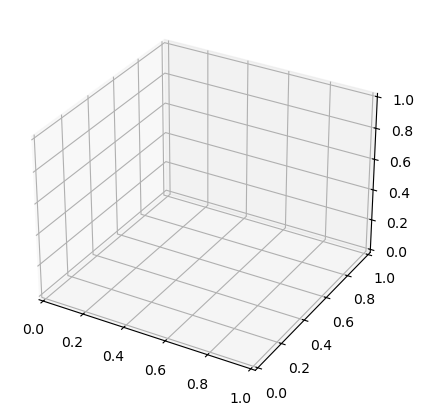

In [11]:

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
# %matplotlib notebook

fig = plt.figure(figsize=(6, 5))
ax = fig.add_subplot(111, projection='3d')
sc = ax.scatter(projected[:, 0], projected[:, 1], projected[:, 2],
                c=a['M_H'].values[:100], cmap='BrBG', s=1)

ax.set_xlabel('Component 0')
ax.set_ylabel('Component 1')
ax.set_zlabel('Component 2')
cb = fig.colorbar(sc, ax=ax, shrink=0.5)
cb.set_label('[M/H]')
# plt.title('3D Interactive Scatter Plot')



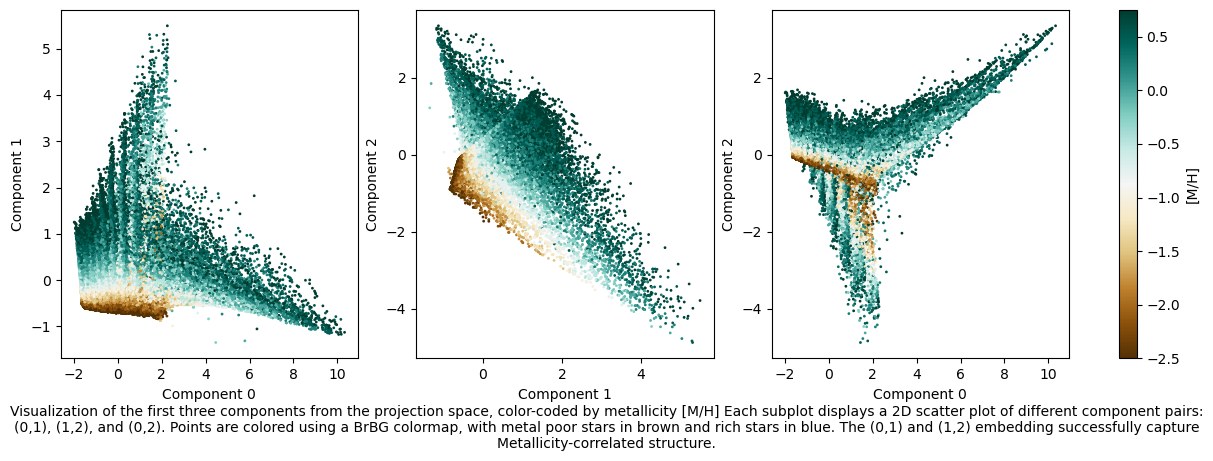

In [ ]:
import matplotlib.pyplot as plt

pairs = [(0, 1), (1, 2), (0, 2)]
fig, axs = plt.subplots(1, 3, figsize=(12, 4), constrained_layout=True)

for ax, (i, j) in zip(axs, pairs):
    sc = ax.scatter(projected[:, i], projected[:, j], s=1, c=a['M_H'].values, cmap='BrBG')
    ax.set_xlabel(f'Component {i}')
    ax.set_ylabel(f'Component {j}')
caption = ("Visualization of the first three components from the projection space, "
           "color-coded by metallicity [M/H] "
           "Each subplot displays a 2D scatter plot of different component pairs: "
           "(0,1), (1,2), and (0,2). Points are colored using a BrBG colormap, "
           "with metal poor stars in brown and rich stars in blue-green. The (0,1) and (1,2) embedding successfully capture "
           "Metallicity-correlated structure.")

plt.figtext(0.5, -0.1, caption, wrap=True, horizontalalignment='center', fontsize=10)

fig.colorbar(sc, ax=axs, location='right', label='[M/H]')

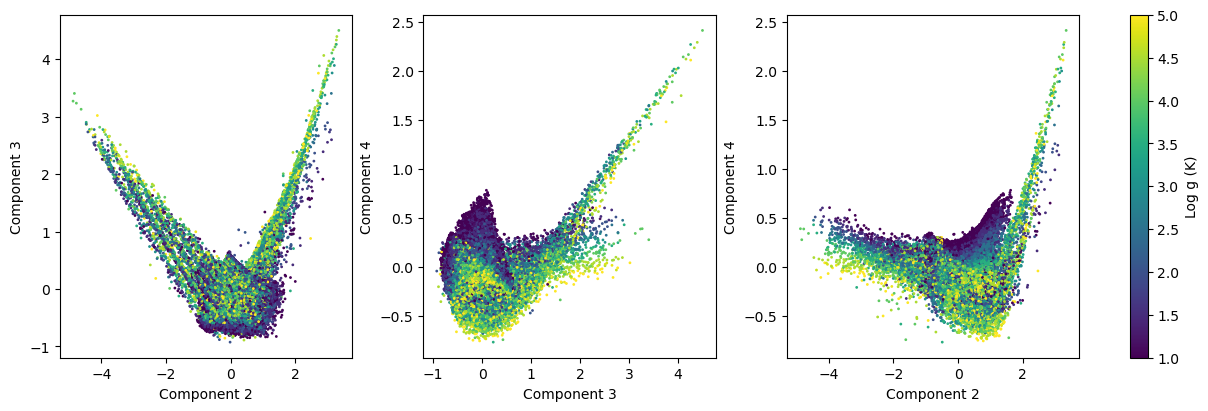

In [38]:
%matplotlib inline
import matplotlib.pyplot as plt
ii = 2
pairs = [(ii, ii+1), (ii+1, ii+2), (ii, ii+2)]
fig, axs = plt.subplots(1, 3, figsize=(12, 4), constrained_layout=True)

for ax, (i, j) in zip(axs, pairs):
    sc = ax.scatter(projected[:, i], projected[:, j], s=1, c=a['log_g'].values, cmap='viridis')
    ax.set_xlabel(f'Component {i}')
    ax.set_ylabel(f'Component {j}')
    # ax.set_title(f'{i} vs {j}')
# caption = ("Visualization of the first three components from the projection space, "
#            "color-coded by gravity (log g) "
#            "Each subplot displays a 2D scatter plot of different component pairs: "
#            "(0,1), (1,2), and (0,2). Points are colored using a red-blue colormap, "
#            "with cooler stars in red and hotter stars in blue. The embedding captures "
#            "temperature-correlated structure, indicating that the projection retains "
#            "astrophysically meaningful information.")
# plt.figtext(0.5, -0.1, caption, wrap=True, horizontalalignment='center', fontsize=10)

fig.colorbar(sc, ax=axs, location='right', label='Log g (K)')
fig.show()

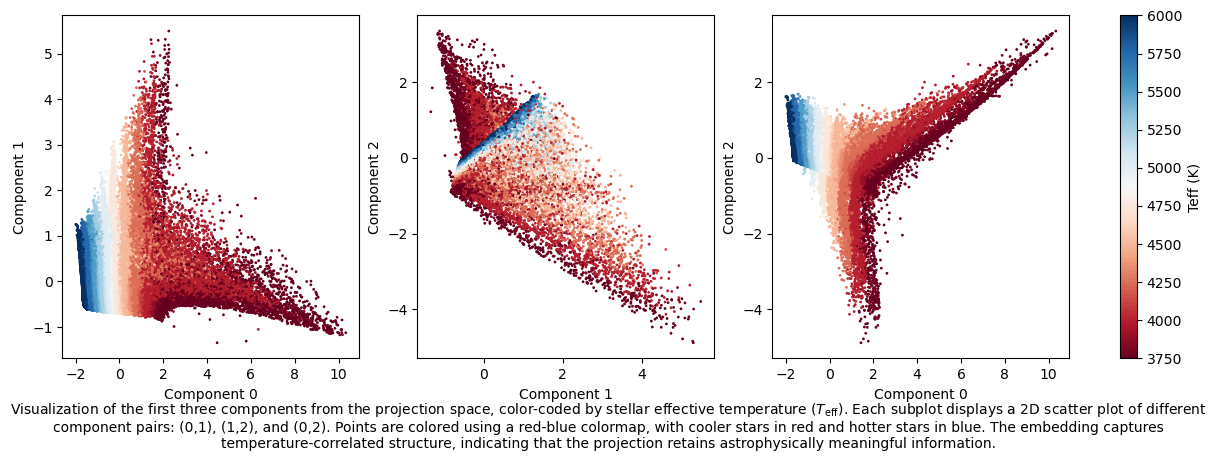

In [82]:
import matplotlib.pyplot as plt

pairs = [(0, 1), (1, 2), (0, 2)]
fig, axs = plt.subplots(1, 3, figsize=(12, 4), constrained_layout=True)

for ax, (i, j) in zip(axs, pairs):
    sc = ax.scatter(projected[:, i], projected[:, j], s=1, c=a['T_eff'].values, cmap='RdBu')
    ax.set_xlabel(f'Component {i}')
    ax.set_ylabel(f'Component {j}')
    # ax.set_title(f'{i} vs {j}')
caption = ("Visualization of the first three components from the projection space, "
           "color-coded by stellar effective temperature ($T_\\mathrm{eff}$). "
           "Each subplot displays a 2D scatter plot of different component pairs: "
           "(0,1), (1,2), and (0,2). Points are colored using a red-blue colormap, "
           "with cooler stars in red and hotter stars in blue. The embedding captures "
           "temperature-correlated structure, indicating that the projection retains "
           "astrophysically meaningful information.")

plt.figtext(0.5, -0.1, caption, wrap=True, horizontalalignment='center', fontsize=10)

fig.colorbar(sc, ax=axs, location='right', label='Teff (K)')

In [12]:
import matplotlib.pyplot as plt
import numpy as np
def plot_svd_s(SSList, labels = None, ax=None):
    if ax is None: f, ax = plt.subplots(1, 1, facecolor='w')
    if labels is None: labels = np.arange(len(SSList))
    colors = ['k', 'r','orange','g','b','purple']
    for ii, ss in enumerate(SSList):
        ss0 = ss / torch.sum(ss) 
        ax.plot(np.arange(len(ss0)), ss0, 'o-',label = labels[ii], color=colors[ii], ms=2, lw=0.8)

    ax.set_xscale('log')
    ax.set_yscale('log')

    ax.set_ylabel('Log Singular Value Ratio')
    ax.set_xlabel('Log Rank')    

    if labels is not None: ax.legend()

(0.0, 4096.0)

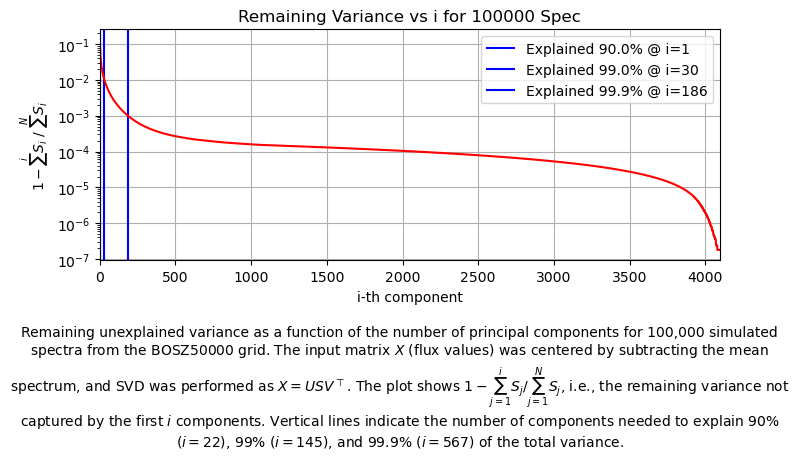

In [13]:
f = plt.figure(figsize=(8,3))
Sratio = 1 - torch.cumsum(S, dim=0) / torch.sum(S)
for i in range(1, 4):
    ratio = 10 ** (-i)
    idx = torch.argmin(torch.abs(Sratio - ratio))
    plt.axvline(idx, color='b', label=f'Explained {100 -100*ratio}% @ i={idx}')
plt.plot(Sratio, 'r-', ms=1)
plt.yscale('log')
plt.grid()
plt.legend()
plt.ylabel(r'$1 - \sum^i S_i$ / $\sum^N S_i $')
plt.xlabel('i-th component')
plt.title(f'Remaining Variance vs i for {num_samples} Spec')
caption=r'Remaining unexplained variance as a function of the number of principal components for 100,000 simulated spectra from the BOSZ50000 grid. The input matrix $X$ (flux values) was centered by subtracting the mean spectrum, and SVD was performed as $X = USV^\top$. The plot shows $1 - \sum_{j=1}^i S_j / \sum_{j=1}^N S_j$, i.e., the remaining variance not captured by the first $i$ components. Vertical lines indicate the number of components needed to explain 90% ($i=22$), 99% ($i=145$), and 99.9% ($i=567$) of the total variance.'
plt.figtext(0.5, -0.5, caption, wrap=True, horizontalalignment='center', fontsize=10)
plt.xlim(-0,4096)

In [16]:
Vt[:10].shape

torch.Size([10, 4096])

In [41]:
def air_to_vac(wave):
    """
    Implements the air to vacuum wavelength conversion described in eqn 65 of
    Griesen 2006
    """
    wlum = wave * 1e5
    return (1+1e-6*(287.6155+1.62887/wlum**2+0.01360/wlum**4)) * wave


In [42]:
air_to_vac(8498)

8500.444156519

Text(0.5, 0.95, 'Top 10 Eigenspectrums $V_i$ with explained variance in %. The Ca II triplet, Na lines and TiO1,TiO2 lines are shown in red, orange, and blue.')

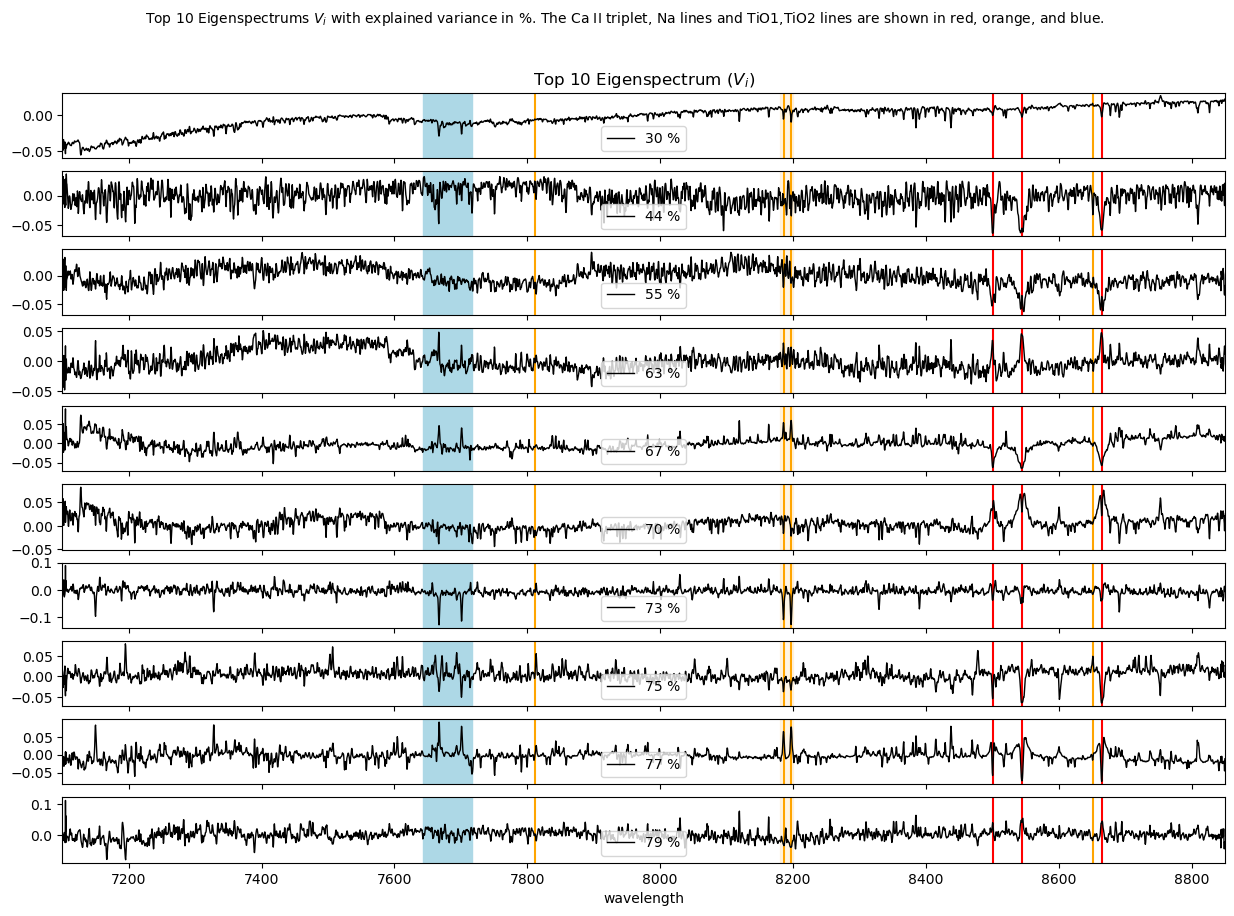

In [110]:
K = 10
ratios = 100 * torch.cumsum(S, dim=0) / torch.sum(S)
f, axes = plt.subplots(K, 1, figsize=(15, 10), sharex=True)
axes[-1].set(xlim=(wave[0], wave[-1]), xlabel='wavelength')
for i in range(K):
    for ca in [8498, 8542, 8662,]:
        axes[i].axvline(air_to_vac(ca), color='red')
    for na in [8183.255, 8194.8, 8649, 7810]:
        axes[i].axvline(air_to_vac(na), color='orange')
    # axes[i].axvline(8183.255, color='y')
    axes[i].axvspan(7643.25, 7717.25, color='lightblue')
    axes[i].axvspan(8180,8200, color='orange', alpha=0.1)

    axes[i].plot(wave, Vt[i], c='k',lw=1, label=f'{ratios[i]:.0f} %')
    axes[i].legend(loc='lower center')


axes[0].set_title(fr'Top {K} Eigenspectrum ($V_i$)')
caption=r'Top 10 Eigenspectrums $V_i$ with explained variance in %. The Ca II triplet, Na lines and TiO1,TiO2 lines are shown in red, orange, and blue.'
plt.figtext(0.5, 0.95, caption, wrap=True, horizontalalignment='center', fontsize=10)